# Datathon #4: Neural Networks

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import io
from google.colab import files

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

import time

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

#import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

from torch.nn.functional import sigmoid, relu, tanh
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

warnings.filterwarnings('ignore')


In [ ]:
imported=files.upload()

Saving datathon4.csv to datathon4.csv


In [ ]:
df= pd.read_csv('datathon4.csv')

In [ ]:
# Upload the dictionary
uploaded2 = files.upload()

Saving datathon4-dictionary.csv to datathon4-dictionary.csv


In [ ]:
# Read the dataset into a Pandas DataFrame

df_dict= pd.read_csv('datathon4-dictionary.csv')


In [ ]:
df_dict['Category'].unique()

array(['identifier', 'demographic', 'APACHE covariate', 'vitals', 'labs',
       'labs blood gas', 'APACHE prediction', 'APACHE comorbidity',
       'APACHE grouping', 'GOSSIS example prediction'], dtype=object)

In [ ]:
id_columns=list(df_dict[df_dict['Category']=='identifier']['Variable Name']) #drop from model 1 and 2
APACHE_grouping_columns=list(df_dict[df_dict['Category']=='APACHE grouping']['Variable Name']) #drop from model 1
vital_columns=list(df_dict[df_dict['Category']=='vitals']['Variable Name']) #drop from model 1
labs_columns=list(df_dict[df_dict['Category']=='labs']['Variable Name']) #drop from model 1
labs_blood_gas_columns=list(df_dict[df_dict['Category']=='labs blood gas']['Variable Name']) #drop from model 1
apache_pred_columns=list(df_dict[df_dict['Category']=='APACHE prediction']['Variable Name']) # to drop from both models
id_columns=list(df_dict[df_dict['Category']=='identifier']['Variable Name']) #drop from model 1 and 2
id_columns.append('icu_id') # Also an identifier variable, not relevant to question

In [ ]:
# Drop IDENTIFIER columns
df = df.drop(id_columns, axis=1)
df.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,admit,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,admit,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
# Check for missing values in each column

def get_missing_data(data):
  """
  Returns DataFrame with percent missing data from input data (DataFrame).

  Parameters
  -----
  data (DataFrame): input dataframe

  Returns
  -----
  missing_data (DataFrame): output dataframe with % missing values
  """
  print(data.isnull().sum())

  # Get percentage of missing values in each column
  missing_data_prop={}
  for x,y in enumerate(list(data.isnull().sum())):
    missing_data_prop[data.columns[x]]=(float(y/data.shape[0])*100) #"{:.2f}".format

  missing_data=pd.DataFrame(missing_data_prop.items(), columns=['column', 'percent_missing'])
  return missing_data

get_missing_data(df)

hospital_death                    0
age                            4228
bmi                            3429
elective_surgery                  0
ethnicity                      1395
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 182, dtype: int64


,column,percent_missing
0,hospital_death,0.000000
1,age,4.610033
2,bmi,3.738837
3,elective_surgery,0.000000
4,ethnicity,1.521049
...,...,...
177,leukemia,0.779606
178,lymphoma,0.779606
179,solid_tumor_with_metastasis,0.779606
180,apache_3j_bodysystem,1.812175


In [ ]:
missing_data=get_missing_data(df)
cols_to_drop=list(missing_data[missing_data['percent_missing']>70]['column'])
cols_to_drop #over 70% missing

hospital_death                    0
age                            4228
bmi                            3429
elective_surgery                  0
ethnicity                      1395
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 182, dtype: int64


['fio2_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_min',
 'h1_diasbp_invasive_max',
 'h1_diasbp_invasive_min',
 'h1_mbp_invasive_max',
 'h1_mbp_invasive_min',
 'h1_sysbp_invasive_max',
 'h1_sysbp_invasive_min',
 'd1_lactate_max',
 'd1_lactate_min',
 'h1_albumin_max',
 'h1_albumin_min',
 'h1_bilirubin_max',
 'h1_bilirubin_min',
 'h1_bun_max',
 'h1_bun_min',
 'h1_calcium_max',
 'h1_calcium_min',
 'h1_creatinine_max',
 'h1_creatinine_min',
 'h1_hco3_max',
 'h1_hco3_min',
 'h1_hemaglobin_max',
 'h1_hemaglobin_min',
 'h1_hematocrit_max',
 'h1_hematocrit_min',
 'h1_lactate_max',
 'h1_lactate_min',
 'h1_platelets_max',
 'h1_platelets_min',
 'h1_potassium_max',
 'h1_potassium_min',
 'h1_sodium_max',
 'h1_sodium_min',
 'h1_wbc_max',
 'h1_wbc_min',
 'd1_pao2fio2ratio_max',
 'd1_pao2fio2ratio_min',
 'h1_arterial_pco

# Model 1

In [58]:
# Full model - Model 1
# Drop variables related to labs/blood
df_model1 = df.drop(APACHE_grouping_columns, axis=1)
df_model1 = df_model1.drop(vital_columns, axis=1)
df_model1 = df_model1.drop(labs_columns, axis=1)
df_model1 = df_model1.drop(labs_blood_gas_columns, axis=1)
df_model1 = df_model1.drop(apache_pred_columns, axis=1)

## Filter out columns that are in cols_to_drop and are present in df_model1
cols_to_drop_existing = [col for col in cols_to_drop if col in df_model1.columns]
# Drop the selected columns from df_model1
df_model1_alt = df_model1.drop(cols_to_drop_existing, axis=1)

In [ ]:
df_model1_alt.head
df_model1_alt.shape

(91713, 45)

In [ ]:
# checking the data types
df_model1_alt.dtypes

hospital_death                   int64
age                            float64
bmi                            float64
elective_surgery                 int64
ethnicity                       object
gender                          object
height                         float64
hospital_admit_source           object
icu_admit_source                object
icu_stay_type                   object
icu_type                        object
pre_icu_los_days               float64
readmission_status               int64
weight                         float64
albumin_apache                 float64
apache_2_diagnosis             float64
apache_3j_diagnosis            float64
apache_post_operative            int64
arf_apache                     float64
bilirubin_apache               float64
bun_apache                     float64
creatinine_apache              float64
gcs_eyes_apache                float64
gcs_motor_apache               float64
gcs_unable_apache              float64
gcs_verbal_apache        

Converting "object" datatypes to "float"

In [59]:
from sklearn.preprocessing import LabelEncoder

# Select only the object columns
object_columns = df_model1_alt.select_dtypes(include=['object']).columns

# Apply label encoding to each object column
label_encoder = LabelEncoder()
for column in object_columns:
    df_model1_alt[column] = label_encoder.fit_transform(df_model1_alt[column])

# Convert the entire DataFrame to float
df_model1_alt = df_model1_alt.astype(float)

# Regularized Training of a Neural Network in PyTorch





In [22]:
train_folds=['Train-Fold 1','Train-Fold 2','Train-Fold 3','Train-Fold 4','Train-Fold 5']
validation_folds=['Validation-Fold 1','Validation-Fold 2','Validation-Fold 3','Validation-Fold 4','Validation-Fold 5']


Data preparation

In [72]:
from sklearn.model_selection import ParameterGrid
import numpy as np

import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# 1. Splitting the data into training and testing sets
X=df_model1_alt.drop('hospital_death', axis=1).to_numpy()
Y=df_model1_alt['hospital_death'].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check the mean of the outcome in both training and testing data
print(Y_train.mean())
print(Y_test.mean())

# Define hyperparameters
number_of_input_features = 44
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

0.08624778519830993
0.08651801777244726


# With SMOTE

In [73]:
# Epochs inside CV
train_nn = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Apply SMOTE
  smote = SMOTE(random_state=42)
  X_train_smote, Y_train_fold = smote.fit_resample(X_train_fold_imputed, Y_train_fold)
  X_valid_smote, Y_valid_fold = smote.fit_resample(X_valid_fold_imputed, Y_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_smote)
  X_valid_fold = sc.transform(X_valid_smote)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model with regularization
  model = nn.Sequential(
        nn.Linear(number_of_input_features, number_of_hidden_units),
        nn.Tanh(),
        nn.Linear(number_of_hidden_units, 1),
        nn.Sigmoid()
        )

  # Define the optimizer and loss function
  optimizer = Adam(model.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on validation data
    with t.no_grad():
        model.eval()

        # Train data #

        # Accuracy
        probs = model(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn['accuracy'].append(np.mean(train_accuracy_list))
  train_nn['recall'].append(np.mean(train_recall_list))
  train_nn['precision'].append(np.mean(train_precision_list))
  train_nn['f1-score'].append(np.mean(train_f1_list))
  train_nn['auc'].append(np.mean(train_auc_list))

  validation_nn['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn['recall'].append(np.mean(validation_recall_list))
  validation_nn['precision'].append(np.mean(validation_precision_list))
  validation_nn['f1-score'].append(np.mean(validation_f1_list))
  validation_nn['auc'].append(np.mean(validation_auc_list))


Fold 1, Epoch 0: Train Accuracy: 0.7855238318443298, Recall: 0.8047097868849402, Precision: 0.7749726167603382, F1 Score: 0.7895613040137572, AUC Score: 0.8650310382602786
Fold 1, Epoch 0: Validation Accuracy: 0.7820493578910828, Recall: 0.8023715415019763, Precision: 0.7710333954421671, F1 Score: 0.7863903811716552, AUC Score: 0.8590998470138819
Mean loss for epoch 0: 0.5042036009250809
Fold 1, Epoch 1: Train Accuracy: 0.7858501076698303, Recall: 0.8170715790651278, Precision: 0.7690498753992489, F1 Score: 0.7923337702843195, AUC Score: 0.8643186901170877
Fold 1, Epoch 1: Validation Accuracy: 0.783988356590271, Recall: 0.8176597807442763, Precision: 0.7660704304080492, F1 Score: 0.7910248548032178, AUC Score: 0.8591865621914005
Mean loss for epoch 1: 0.5024806726985002
Fold 1, Epoch 2: Train Accuracy: 0.7804896235466003, Recall: 0.7970838849215968, Precision: 0.771479616696443, F1 Score: 0.784072776626378, AUC Score: 0.8611802101537478
Fold 1, Epoch 2: Validation Accuracy: 0.779029011

In [75]:
print("WITH SMOTE, NO DROPOUT")
pd.concat([pd.DataFrame(train_nn,index=train_folds),pd.DataFrame(validation_nn,index=validation_folds)])

WITH SMOTE, NO DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.783495,0.776280,0.797437,0.786353,0.863150
Train-Fold 2,0.784041,0.777345,0.796901,0.786683,0.864034
Train-Fold 3,0.784482,0.777442,0.797809,0.787229,0.864302
Train-Fold 4,0.784711,0.778434,0.796543,0.787149,0.864462
Train-Fold 5,0.785001,0.779245,0.795875,0.787233,0.864758
Validation-Fold 1,0.779836,0.772057,0.794992,0.782962,0.858007
Validation-Fold 2,0.778908,0.774373,0.788004,0.780738,0.858416
Validation-Fold 3,0.779795,0.774411,0.790280,0.781948,0.859392
Validation-Fold 4,0.780986,0.776487,0.789724,0.782779,0.861299
Validation-Fold 5,0.782323,0.777930,0.790821,0.784049,0.861985


# No SMOTE

In [71]:
# 1. Splitting the data into training and testing sets
X=df_model1_alt.drop('hospital_death', axis=1).to_numpy()
Y=df_model1_alt['hospital_death'].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

without SMOTE

In [25]:
# Define hyperparameters
number_of_input_features = 44
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# Epochs inside CV
train_nn_raw = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn_raw = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_fold_imputed)
  X_valid_fold = sc.transform(X_valid_fold_imputed)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model_raw with regularization
  model_raw = nn.Sequential(
      nn.Linear(number_of_input_features, number_of_hidden_units),
      nn.Tanh(),
      nn.Linear(number_of_hidden_units, 1),
      nn.Sigmoid()
    )

  # Define the optimizer and loss function
  optimizer = Adam(model_raw.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model_raw(X)

        # Adding regularization term for all parameters in the model_raw
        l2_term = sum([(w ** 2).sum() for w in model_raw.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model_raw on validation data
    with t.no_grad():
        model_raw.eval()

        # Train data #

        # Accuracy
        probs = model_raw(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model_raw(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model_raw back to train mode
        model_raw.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn_raw['accuracy'].append(np.mean(train_accuracy_list))
  train_nn_raw['recall'].append(np.mean(train_recall_list))
  train_nn_raw['precision'].append(np.mean(train_precision_list))
  train_nn_raw['f1-score'].append(np.mean(train_f1_list))
  train_nn_raw['auc'].append(np.mean(train_auc_list))

  validation_nn_raw['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn_raw['recall'].append(np.mean(validation_recall_list))
  validation_nn_raw['precision'].append(np.mean(validation_precision_list))
  validation_nn_raw['f1-score'].append(np.mean(validation_f1_list))
  validation_nn_raw['auc'].append(np.mean(validation_auc_list))


Fold 1, Epoch 0: Train Accuracy: 0.9147642254829407, Recall: 0.2036342089670156, Precision: 0.514985014985015, F1 Score: 0.29186128803963196, AUC Score: 0.8335630518852534
Fold 1, Epoch 0: Validation Accuracy: 0.9148153066635132, Recall: 0.2007905138339921, Precision: 0.5152129817444219, F1 Score: 0.28896473265073946, AUC Score: 0.8289998134106731
Mean loss for epoch 0: 0.29841307292030034
Fold 1, Epoch 1: Train Accuracy: 0.9157523512840271, Recall: 0.2559747185463164, Precision: 0.5238480194017785, F1 Score: 0.34390340984476586, AUC Score: 0.8330173463420253
Fold 1, Epoch 1: Validation Accuracy: 0.9122257232666016, Recall: 0.2339920948616601, Precision: 0.4813008130081301, F1 Score: 0.31489361702127666, AUC Score: 0.8264189263479164
Mean loss for epoch 1: 0.29291642525459183
Fold 1, Epoch 2: Train Accuracy: 0.916024923324585, Recall: 0.1404305747580486, Precision: 0.5520186335403726, F1 Score: 0.22390174775625885, AUC Score: 0.8322364099394781
Fold 1, Epoch 2: Validation Accuracy: 0.9

In [26]:
print("NO SMOTE, NO DROPOUT")
pd.concat([pd.DataFrame(train_nn_raw,index=train_folds),pd.DataFrame(validation_nn_raw,index=validation_folds)])

NO SMOTE, NO DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.915808,0.544661,0.179834,0.264660,0.828147
Train-Fold 2,0.915709,0.549547,0.164645,0.245934,0.827437
Train-Fold 3,0.915585,0.547678,0.169315,0.249929,0.827785
Train-Fold 4,0.915462,0.547866,0.164891,0.244042,0.828556
Train-Fold 5,0.915700,0.552701,0.160989,0.240873,0.828358
Validation-Fold 1,0.913664,0.505788,0.164308,0.242062,0.821865
Validation-Fold 2,0.914456,0.526856,0.156522,0.233924,0.822235
Validation-Fold 3,0.914560,0.527789,0.164103,0.241261,0.824615
Validation-Fold 4,0.915170,0.543975,0.163332,0.241414,0.827422
Validation-Fold 5,0.915440,0.548432,0.160824,0.240086,0.827621


# Testing: no SMOTE

In [29]:
# Impute missing values and normalize data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# normalizing
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train_imputed)
X_test_norm = sc.transform(X_test_imputed)

X_test_tensor = t.Tensor(X_test_norm).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

# Test the best model on the testing dataset
with t.no_grad():
    model_raw.eval()

    probs = model_raw(X_test_tensor)
    prediction = (probs >= 0.5).type(t.LongTensor).view(-1)

    #Calculating accuracy
    testing_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

    #Calculate the percision
    precision = precision_score(Y_test_tensor, prediction.cpu().numpy())

    # Get the predicted probabilities for the positive class from the validation data
    fpr, tpr, thresholds = roc_curve(Y_test_tensor.cpu().numpy(), probs.cpu().numpy())

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    #Calculate AUC on validation data
    auc_score = roc_auc_score(Y_test_tensor, probs.cpu().numpy())

    #Calculate F1 score on validation data
    f1 = f1_score(Y_test_tensor, prediction.cpu().numpy())

    #calculate recall
    recall = recall_score(Y_test_tensor, prediction.cpu().numpy())

    # Print accuracy for the current epoch
    print(f'"Testing Accuracy: {testing_accuracy}", "AUC Score: {auc_score}", "F1 Score: {f1}", "Precision: {precision}", ""Recall: {recall}"')



"Testing Accuracy: 0.9156626462936401", "AUC Score: 0.8201902265106665", "F1 Score: 0.17756512493354598", "Precision: 0.5680272108843537", ""Recall: 0.10522999369880277"


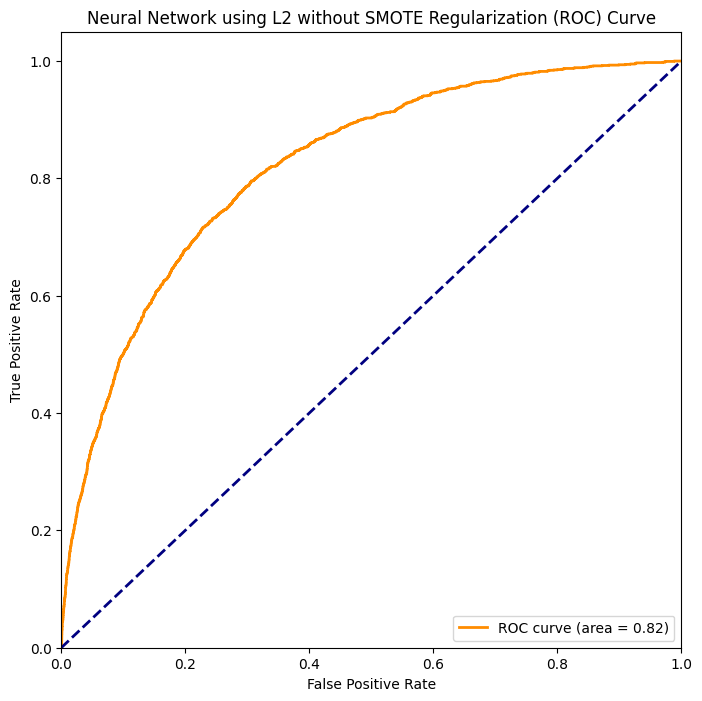

In [31]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network using L2 without SMOTE Regularization (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Dropout In Neural Networks

# With SMOTE with DROPOUT

In [76]:
# Define hyperparameters
number_of_input_features = 44
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)
dropout_probablity = 0.3

# Epochs inside CV
train_nn_smote_dropout = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn_smote_dropout = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Apply SMOTE
  smote = SMOTE(random_state=42)
  X_train_smote, Y_train_fold = smote.fit_resample(X_train_fold_imputed, Y_train_fold)
  X_valid_smote, Y_valid_fold = smote.fit_resample(X_valid_fold_imputed, Y_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_smote)
  X_valid_fold = sc.transform(X_valid_smote)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model_smote_dropout with regularization
  model_smote_dropout = nn.Sequential(
      nn.Linear(number_of_input_features, number_of_hidden_units),
      nn.Tanh(),
      nn.Dropout(dropout_probablity),
      nn.Linear(number_of_hidden_units, 1),
      nn.Sigmoid()
    )

  # Define the optimizer and loss function
  optimizer = Adam(model_smote_dropout.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model_smote_dropout(X)

        # Adding regularization term for all parameters in the model_smote_dropout
        l2_term = sum([(w ** 2).sum() for w in model_smote_dropout.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model_smote_dropout on validation data
    with t.no_grad():
        model_smote_dropout.eval()

        # Train data #

        # Accuracy
        probs = model_smote_dropout(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model_smote_dropout(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model_smote_dropout back to train mode
        model_smote_dropout.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn_smote_dropout['accuracy'].append(np.mean(train_accuracy_list))
  train_nn_smote_dropout['recall'].append(np.mean(train_recall_list))
  train_nn_smote_dropout['precision'].append(np.mean(train_precision_list))
  train_nn_smote_dropout['f1-score'].append(np.mean(train_f1_list))
  train_nn_smote_dropout['auc'].append(np.mean(train_auc_list))

  validation_nn_smote_dropout['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn_smote_dropout['recall'].append(np.mean(validation_recall_list))
  validation_nn_smote_dropout['precision'].append(np.mean(validation_precision_list))
  validation_nn_smote_dropout['f1-score'].append(np.mean(validation_f1_list))
  validation_nn_smote_dropout['auc'].append(np.mean(validation_auc_list))



Fold 1, Epoch 0: Train Accuracy: 0.7746816277503967, Recall: 0.7692651912069062, Precision: 0.7776898137676242, F1 Score: 0.7734545624970708, AUC Score: 0.8551693089264607
Fold 1, Epoch 0: Validation Accuracy: 0.7706764340400696, Recall: 0.7690357222760832, Precision: 0.7715675271230826, F1 Score: 0.7702995443340555, AUC Score: 0.8501231367756497
Mean loss for epoch 0: 0.5156534222873189
Fold 1, Epoch 1: Train Accuracy: 0.7820651531219482, Recall: 0.8052877892342402, Precision: 0.769546005274036, F1 Score: 0.7870113067959219, AUC Score: 0.8612951959527211
Fold 1, Epoch 1: Validation Accuracy: 0.7807815670967102, Recall: 0.8076664926541874, Precision: 0.7664543524416136, F1 Score: 0.786520933948219, AUC Score: 0.8577476764473108
Mean loss for epoch 1: 0.5147707233260433
Fold 1, Epoch 2: Train Accuracy: 0.779370903968811, Recall: 0.780564204873865, Precision: 0.7787057532411972, F1 Score: 0.7796338715384472, AUC Score: 0.8600951288318143
Fold 1, Epoch 2: Validation Accuracy: 0.7745916843

In [78]:
print("WITH SMOTE, WITH DROPOUT")
pd.concat([pd.DataFrame(train_nn_smote_dropout,index=train_folds),pd.DataFrame(validation_nn_smote_dropout,index=validation_folds)])


WITH SMOTE, WITH DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.778853,0.779657,0.777761,0.778515,0.859024
Train-Fold 2,0.780322,0.779906,0.781451,0.780466,0.860705
Train-Fold 3,0.780830,0.778902,0.784758,0.781576,0.860818
Train-Fold 4,0.781161,0.779068,0.785314,0.781973,0.861058
Train-Fold 5,0.781292,0.779688,0.784574,0.781915,0.861370
Validation-Fold 1,0.775966,0.775545,0.777101,0.776130,0.855119
Validation-Fold 2,0.774567,0.776736,0.771062,0.773622,0.855621
Validation-Fold 3,0.775883,0.775807,0.776522,0.775872,0.856418
Validation-Fold 4,0.777891,0.777560,0.778908,0.777987,0.858524
Validation-Fold 5,0.779312,0.779034,0.780233,0.779390,0.859500


# NO SMOTE with DROPOUT

In [36]:
# Define hyperparameters
number_of_input_features = 44
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)
dropout_probablity = 0.3

# Epochs inside CV
train_nn_raw_dropout = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn_raw_dropout = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_fold_imputed)
  X_valid_fold = sc.transform(X_valid_fold_imputed)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model_raw_dropout with regularization
  model_raw_dropout = nn.Sequential(
      nn.Linear(number_of_input_features, number_of_hidden_units),
      nn.Tanh(),
      nn.Dropout(dropout_probablity),
      nn.Linear(number_of_hidden_units, 1),
      nn.Sigmoid()
    )

  # Define the optimizer and loss function
  optimizer = Adam(model_raw_dropout.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model_raw_dropout(X)

        # Adding regularization term for all parameters in the model_raw_dropout
        l2_term = sum([(w ** 2).sum() for w in model_raw_dropout.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model_raw_dropout on validation data
    with t.no_grad():
        model_raw_dropout.eval()

        # Train data #

        # Accuracy
        probs = model_raw_dropout(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model_raw_dropout(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model_raw_dropout back to train mode
        model_raw_dropout.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn_raw_dropout['accuracy'].append(np.mean(train_accuracy_list))
  train_nn_raw_dropout['recall'].append(np.mean(train_recall_list))
  train_nn_raw_dropout['precision'].append(np.mean(train_precision_list))
  train_nn_raw_dropout['f1-score'].append(np.mean(train_f1_list))
  train_nn_raw_dropout['auc'].append(np.mean(train_auc_list))

  validation_nn_raw_dropout['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn_raw_dropout['recall'].append(np.mean(validation_recall_list))
  validation_nn_raw_dropout['precision'].append(np.mean(validation_precision_list))
  validation_nn_raw_dropout['f1-score'].append(np.mean(validation_f1_list))
  validation_nn_raw_dropout['auc'].append(np.mean(validation_auc_list))



Fold 1, Epoch 0: Train Accuracy: 0.9172515869140625, Recall: 0.1684771874382777, Precision: 0.5686666666666667, F1 Score: 0.2599420996495505, AUC Score: 0.8320994689038819
Fold 1, Epoch 0: Validation Accuracy: 0.9158375263214111, Recall: 0.16126482213438736, Precision: 0.5396825396825397, F1 Score: 0.24832623250152158, AUC Score: 0.8269046776146161
Mean loss for epoch 0: 0.30318368416716035
Fold 1, Epoch 1: Train Accuracy: 0.9135375618934631, Recall: 0.2297057080782145, Precision: 0.4974337040205304, F1 Score: 0.31428185380354007, AUC Score: 0.8140800607035594
Fold 1, Epoch 1: Validation Accuracy: 0.9116123914718628, Recall: 0.21739130434782608, Precision: 0.4725085910652921, F1 Score: 0.2977801840822956, AUC Score: 0.8009945535371353
Mean loss for epoch 1: 0.29897123120867264
Fold 1, Epoch 2: Train Accuracy: 0.9151390194892883, Recall: 0.06596879320560932, Precision: 0.5699658703071673, F1 Score: 0.11825101787927067, AUC Score: 0.8257498542252172
Fold 1, Epoch 2: Validation Accuracy: 

In [37]:
print("NO SMOTE, WITH DROPOUT")
pd.concat([pd.DataFrame(train_nn_raw_dropout,index=train_folds),pd.DataFrame(validation_nn_raw_dropout,index=validation_folds)])


NO SMOTE, WITH DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.915677,0.558602,0.132925,0.208083,0.824946
Train-Fold 2,0.915674,0.561946,0.137043,0.211639,0.827712
Train-Fold 3,0.915761,0.560511,0.141790,0.217889,0.828749
Train-Fold 4,0.915626,0.561997,0.141356,0.216007,0.828999
Train-Fold 5,0.915744,0.564582,0.139264,0.213940,0.830158
Validation-Fold 1,0.914154,0.523001,0.121858,0.190776,0.817456
Validation-Fold 2,0.914671,0.535818,0.131304,0.202134,0.822081
Validation-Fold 3,0.914969,0.539397,0.138287,0.211428,0.825056
Validation-Fold 4,0.915444,0.557124,0.140465,0.214385,0.827372
Validation-Fold 5,0.915562,0.558534,0.138959,0.213114,0.828680


## Testing: no SMOTE with dropout

In [63]:
# Test the best model on the testing dataset
with t.no_grad():
    model_raw_dropout.eval()

    probs = model_raw_dropout(X_test_tensor)
    prediction = (probs >= 0.5).type(t.LongTensor).view(-1)

    #Calculating accuracy
    testing_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

    #Calculate the percision
    precision = precision_score(Y_test_tensor, prediction.cpu().numpy())

    # Get the predicted probabilities for the positive class from the validation data
    fpr, tpr, thresholds = roc_curve(Y_test_tensor.cpu().numpy(), probs.cpu().numpy())

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    #Calculate AUC on validation data
    auc_score = roc_auc_score(Y_test_tensor, probs.cpu().numpy())

    #Calculate F1 score on validation data
    f1 = f1_score(Y_test_tensor, prediction.cpu().numpy())

    #calculate recall
    recall = recall_score(Y_test_tensor, prediction.cpu().numpy())

    # Print accuracy for the current epoch
    print(f'"Testing Accuracy: {testing_accuracy}", "AUC Score: {auc_score}", "F1 Score: {f1}", "Precision: {precision}", ""Recall: {recall}"')


"Testing Accuracy: 0.9147903919219971", "AUC Score: 0.8368477098855992", "F1 Score: 0.0767867690490254", "Precision: 0.6132075471698113", ""Recall: 0.04095778197857593"


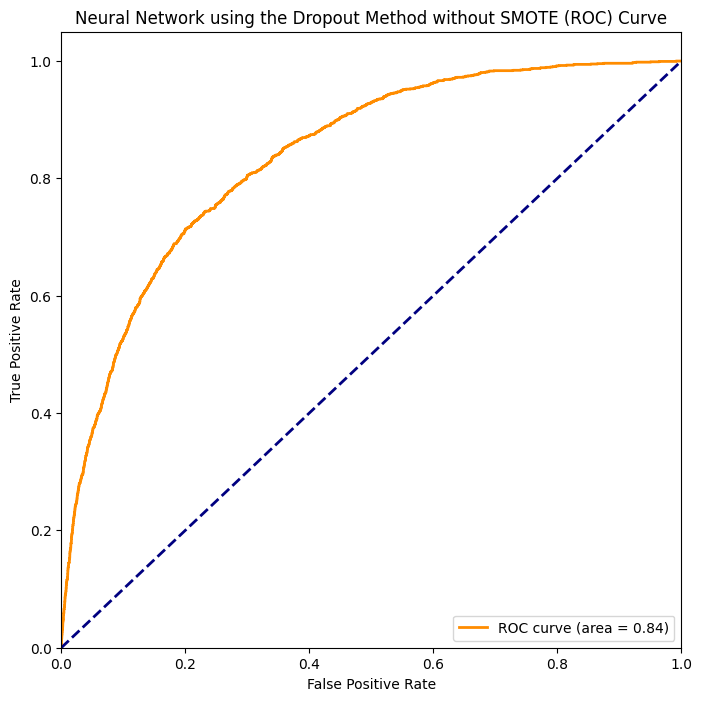

In [64]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network using the Dropout Method without SMOTE (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

testing

without SMOTE

In [ ]:
# Define hyperparameters
number_of_input_features = 44
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
dropout_probablity = 0.3  # Probability of dropping out a neuron in dropout layer


sc = StandardScaler()

# Impute missing values and normalize data
# Impute missing values and normalize data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#normalizing
sc = StandardScaler()
X_test_norm = sc.fit_transform(X_test_imputed)


X_test_tensor = t.Tensor(X_test_norm).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

# Define the neural network model with regularization
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),
    Tanh(),
    Dropout(dropout_probablity),  # Dropout layer to prevent overfitting
    Linear(number_of_hidden_units, 1),
    Sigmoid()
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Test the best model on the testing dataset
with t.no_grad():
    model.eval()

    probs = model(X_test_tensor)
    prediction = (probs >= 0.5).type(t.LongTensor).view(-1)

    #Calculateing accuracy
    testing_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

    #Calculate the percision
    precision = precision_score(Y_test_tensor, prediction.cpu().numpy())

    # Get the predicted probabilities for the positive class from the validation data
    fpr, tpr, thresholds = roc_curve(Y_test_tensor.cpu().numpy(), probs.cpu().numpy())

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    #Calculate AUC on validation data
    auc_score = roc_auc_score(Y_test_tensor, probs.cpu().numpy())

    #Calculate F1 score on validation data
    f1 = f1_score(Y_test_tensor, prediction.cpu().numpy())

    #calculate recall
    recall_value = recall_score(Y_test_tensor, prediction.cpu().numpy())

    # Print accuracy for the current epoch
    print(f'"Testing Accuracy: {testing_accuracy}", "AUC Score: {auc_score}", "F1 Score: {f1}", "Precision: {precision}", ""Recall: {recall}"')


"Testing Accuracy: 0.8389031291007996", "AUC Score: 0.7137883665669216", "F1 Score: 0.2762674504041146", "Precision: 0.22596153846153846", ""Recall: 0.8147448015122873"


# Model 2

In [83]:
# Full model - Model 2
# Drop variables not needed
df_model2 = df.drop(APACHE_grouping_columns, axis=1)
df_model2 = df_model2.drop(apache_pred_columns, axis=1)

## Filter out columns that are in cols_to_drop and are present in df_model2
cols_to_drop_existing = [col for col in cols_to_drop if col in df_model2.columns]
# Drop the selected columns from df_model2
df_model2_alt = df_model2.drop(cols_to_drop_existing, axis=1)

In [ ]:
df_model2_alt.head
df_model2_alt.shape

(91713, 123)

In [ ]:
# checking the data types
df_model2_alt.dtypes

hospital_death                   int64
age                            float64
bmi                            float64
elective_surgery                 int64
ethnicity                       object
                                ...   
hepatic_failure                float64
immunosuppression              float64
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
Length: 123, dtype: object

Converting "object" datatypes to "float"

In [84]:
from sklearn.preprocessing import LabelEncoder

# Select only the object columns
object_columns = df_model2_alt.select_dtypes(include=['object']).columns

# Apply label encoding to each object column
label_encoder = LabelEncoder()
for column in object_columns:
    df_model2_alt[column] = label_encoder.fit_transform(df_model2_alt[column])

# Convert the entire DataFrame to float
df_model2_alt = df_model2_alt.astype(float)

# Regularized Training of a Neural Network in PyTorch

In [86]:
# Splitting the data into training and testing sets
X=df_model2_alt.drop('hospital_death', axis=1).to_numpy()
Y=df_model2_alt['hospital_death'].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check the mean of the outcome column in both training and testing data
print(Y_train.mean())
print(Y_test.mean())

# Define hyperparameters
number_of_input_features = 122
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

0.08624778519830993
0.08651801777244726


# With SMOTE

In [51]:
# Define dictionary
train_nn_smote2 = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn_smote2 = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Apply SMOTE
  smote = SMOTE(random_state=42)
  X_train_smote, Y_train_fold = smote.fit_resample(X_train_fold_imputed, Y_train_fold)
  X_valid_smote, Y_valid_fold = smote.fit_resample(X_valid_fold_imputed, Y_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_smote)
  X_valid_fold = sc.transform(X_valid_smote)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model_smote2 with regularization
  model_smote2 = nn.Sequential(
      nn.Linear(number_of_input_features, number_of_hidden_units),
      nn.Tanh(),
      nn.Linear(number_of_hidden_units, 1),
      nn.Sigmoid()
    )

  # Define the optimizer and loss function
  optimizer = Adam(model_smote2.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model_smote2(X)

        # Adding regularization term for all parameters in the model_smote2
        l2_term = sum([(w ** 2).sum() for w in model_smote2.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model_smote2 on validation data
    with t.no_grad():
        model_smote2.eval()

        # Train data #

        # Accuracy
        probs = model_smote2(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model_smote2(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model_smote2 back to train mode
        model_smote2.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn_smote2['accuracy'].append(np.mean(train_accuracy_list))
  train_nn_smote2['recall'].append(np.mean(train_recall_list))
  train_nn_smote2['precision'].append(np.mean(train_precision_list))
  train_nn_smote2['f1-score'].append(np.mean(train_f1_list))
  train_nn_smote2['auc'].append(np.mean(train_auc_list))

  validation_nn_smote2['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn_smote2['recall'].append(np.mean(validation_recall_list))
  validation_nn_smote2['precision'].append(np.mean(validation_precision_list))
  validation_nn_smote2['f1-score'].append(np.mean(validation_f1_list))
  validation_nn_smote2['auc'].append(np.mean(validation_auc_list))


Fold 1, Epoch 0: Train Accuracy: 0.7853653430938721, Recall: 0.7637834915070945, Precision: 0.7982384348571652, F1 Score: 0.7806309611151871, AUC Score: 0.8679588948006642
Fold 1, Epoch 0: Validation Accuracy: 0.7813035845756531, Recall: 0.758147512864494, Precision: 0.7949640287769785, F1 Score: 0.7761194029850746, AUC Score: 0.8605756651978469
Mean loss for epoch 0: 0.503778213618977
Fold 1, Epoch 1: Train Accuracy: 0.7877705693244934, Recall: 0.8014655156340312, Precision: 0.7800987259990563, F1 Score: 0.7906377891203384, AUC Score: 0.869859106513224
Fold 1, Epoch 1: Validation Accuracy: 0.7868968844413757, Recall: 0.8070698784398538, Precision: 0.7757706093189964, F1 Score: 0.7911107862129464, AUC Score: 0.8649163878871363
Mean loss for epoch 1: 0.5007522385928512
Fold 1, Epoch 2: Train Accuracy: 0.7910987734794617, Recall: 0.7952939421624746, Precision: 0.7886766636466173, F1 Score: 0.7919714805599911, AUC Score: 0.8719254728295828
Fold 1, Epoch 2: Validation Accuracy: 0.783168017

In [52]:
print("WITH SMOTE, NO DROPOUT")
pd.concat([pd.DataFrame(train_nn_smote2,index=train_folds),pd.DataFrame(validation_nn_smote2,index=validation_folds)])

WITH SMOTE, NO DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.790277,0.781249,0.806905,0.793614,0.870132
Train-Fold 2,0.791780,0.784672,0.804724,0.794393,0.871412
Train-Fold 3,0.792601,0.785742,0.805025,0.795103,0.872255
Train-Fold 4,0.793086,0.786334,0.805305,0.795535,0.872542
Train-Fold 5,0.793689,0.787335,0.805122,0.795980,0.873133
Validation-Fold 1,0.783593,0.775764,0.798352,0.786682,0.862435
Validation-Fold 2,0.783720,0.780729,0.789617,0.784933,0.862364
Validation-Fold 3,0.786824,0.782247,0.795407,0.788571,0.865488
Validation-Fold 4,0.789616,0.784422,0.799188,0.791543,0.868731
Validation-Fold 5,0.791293,0.785924,0.801053,0.793251,0.870448


# No SMOTE

In [87]:
# Epochs inside CV
train_nn_raw2 = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn_raw2 = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_fold_imputed)
  X_valid_fold = sc.transform(X_valid_fold_imputed)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model_raw2 with regularization
  model_raw2 = nn.Sequential(
      nn.Linear(number_of_input_features, number_of_hidden_units),
      nn.Tanh(),
      nn.Linear(number_of_hidden_units, 1),
      nn.Sigmoid()
    )

  # Define the optimizer and loss function
  optimizer = Adam(model_raw2.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model_raw2(X)

        # Adding regularization term for all parameters in the model_raw2
        l2_term = sum([(w ** 2).sum() for w in model_raw2.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model_raw2 on validation data
    with t.no_grad():
        model_raw2.eval()

        # Train data #

        # Accuracy
        probs = model_raw2(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model_raw2(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model_raw2 back to train mode
        model_raw2.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn_raw2['accuracy'].append(np.mean(train_accuracy_list))
  train_nn_raw2['recall'].append(np.mean(train_recall_list))
  train_nn_raw2['precision'].append(np.mean(train_precision_list))
  train_nn_raw2['f1-score'].append(np.mean(train_f1_list))
  train_nn_raw2['auc'].append(np.mean(train_auc_list))

  validation_nn_raw2['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn_raw2['recall'].append(np.mean(validation_recall_list))
  validation_nn_raw2['precision'].append(np.mean(validation_precision_list))
  validation_nn_raw2['f1-score'].append(np.mean(validation_f1_list))
  validation_nn_raw2['auc'].append(np.mean(validation_auc_list))



Fold 1, Epoch 0: Train Accuracy: 0.9189382791519165, Recall: 0.11751925735729804, Precision: 0.672316384180791, F1 Score: 0.20006724949562876, AUC Score: 0.8487148609230849
Fold 1, Epoch 0: Validation Accuracy: 0.9174730777740479, Recall: 0.09802371541501977, Precision: 0.6391752577319587, F1 Score: 0.16997943797121318, AUC Score: 0.8432443315017316
Mean loss for epoch 0: 0.30365769990620883
Fold 1, Epoch 1: Train Accuracy: 0.9220730662345886, Recall: 0.15879913095002962, Precision: 0.7184986595174263, F1 Score: 0.260109996764801, AUC Score: 0.8365270719285851
Fold 1, Epoch 1: Validation Accuracy: 0.918904185295105, Recall: 0.1391304347826087, Precision: 0.6353790613718412, F1 Score: 0.2282749675745785, AUC Score: 0.8370408996140577
Mean loss for epoch 1: 0.29885021853349514
Fold 1, Epoch 2: Train Accuracy: 0.9212211966514587, Recall: 0.15287379024293896, Precision: 0.6979260595130748, F1 Score: 0.2508101101749838, AUC Score: 0.825505206839886
Fold 1, Epoch 2: Validation Accuracy: 0.91

In [88]:
print("NO SMOTE, NO DROPOUT")
pd.concat([pd.DataFrame(train_nn_raw2,index=train_folds),pd.DataFrame(validation_nn_raw2,index=validation_folds)])

NO SMOTE, NO DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.919087,0.683350,0.157209,0.236455,0.842040
Train-Fold 2,0.918314,0.636906,0.190500,0.271339,0.841857
Train-Fold 3,0.918466,0.633312,0.188092,0.270736,0.840724
Train-Fold 4,0.918818,0.632591,0.191847,0.277258,0.841395
Train-Fold 5,0.919088,0.629522,0.196285,0.284273,0.841918
Validation-Fold 1,0.917299,0.639377,0.143320,0.216140,0.837822
Validation-Fold 2,0.917022,0.608233,0.180395,0.257137,0.835487
Validation-Fold 3,0.917362,0.608188,0.183205,0.262301,0.836576
Validation-Fold 4,0.918508,0.622558,0.190869,0.275215,0.839827
Validation-Fold 5,0.918921,0.623753,0.195239,0.282795,0.840600


# Testing: no SMOTE

In [89]:
# Impute missing values and normalize data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#normalizing
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train_imputed)
X_test_norm = sc.transform(X_test_imputed)

X_test_tensor = t.Tensor(X_test_norm).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

# Test the best model on the testing dataset
with t.no_grad():

    model_raw2.eval()
    probs = model_raw2(X_test_tensor)
    prediction = (probs >= 0.5).type(t.LongTensor).view(-1)

    #Calculating accuracy
    testing_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

    #Calculate the percision
    precision = precision_score(Y_test_tensor, prediction.cpu().numpy())

    # Get the predicted probabilities for the positive class from the validation data
    fpr, tpr, thresholds = roc_curve(Y_test_tensor.cpu().numpy(), probs.cpu().numpy())

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    #Calculate AUC on validation data
    auc_score = roc_auc_score(Y_test_tensor, probs.cpu().numpy())

    #Calculate F1 score on validation data
    f1 = f1_score(Y_test_tensor, prediction.cpu().numpy())

    #calculate recall
    recall = recall_score(Y_test_tensor, prediction.cpu().numpy())

    # Print accuracy for the current epoch
    print(f'"Testing Accuracy: {testing_accuracy}", "AUC Score: {auc_score}", "F1 Score: {f1}", "Precision: {precision}", ""Recall: {recall}"')




"Testing Accuracy: 0.9207872152328491", "AUC Score: 0.8517561183963219", "F1 Score: 0.378262729995721", "Precision: 0.5893333333333334", ""Recall: 0.27851291745431633"


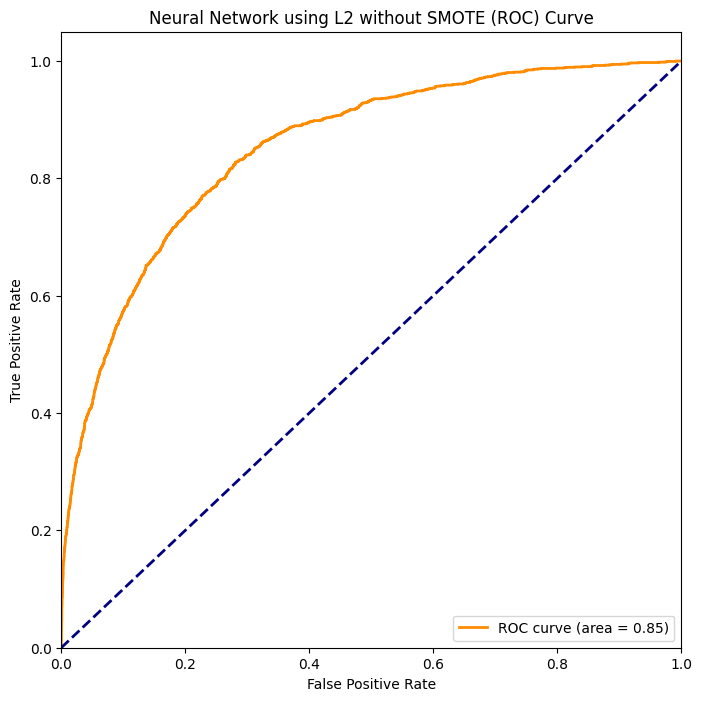

In [90]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network using L2 without SMOTE (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Dropout In Neural Networks

# With SMOTE with DROPOUT

In [93]:
# Define hyperparameters
number_of_input_features = 122
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)
dropout2_probablity = 0.3

# Epochs inside CV
train_nn_smote_dropout2 = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn_smote_dropout2 = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Apply SMOTE
  smote = SMOTE(random_state=42)
  X_train_smote, Y_train_fold = smote.fit_resample(X_train_fold_imputed, Y_train_fold)
  X_valid_smote, Y_valid_fold = smote.fit_resample(X_valid_fold_imputed, Y_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_smote)
  X_valid_fold = sc.transform(X_valid_smote)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model_smote_dropout2 with regularization
  model_smote_dropout2 = nn.Sequential(
      nn.Linear(number_of_input_features, number_of_hidden_units),
      nn.Tanh(),
      nn.Dropout(dropout_probablity),
      nn.Linear(number_of_hidden_units, 1),
      nn.Sigmoid()
    )

  # Define the optimizer and loss function
  optimizer = Adam(model_smote_dropout2.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model_smote_dropout2(X)

        # Adding regularization term for all parameters in the model_smote_dropout2
        l2_term = sum([(w ** 2).sum() for w in model_smote_dropout2.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model_smote_dropout2 on validation data
    with t.no_grad():
        model_smote_dropout2.eval()

        # Train data #

        # Accuracy
        probs = model_smote_dropout2(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model_smote_dropout2(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model_smote_dropout2 back to train mode
        model_smote_dropout2.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn_smote_dropout2['accuracy'].append(np.mean(train_accuracy_list))
  train_nn_smote_dropout2['recall'].append(np.mean(train_recall_list))
  train_nn_smote_dropout2['precision'].append(np.mean(train_precision_list))
  train_nn_smote_dropout2['f1-score'].append(np.mean(train_f1_list))
  train_nn_smote_dropout2['auc'].append(np.mean(train_auc_list))

  validation_nn_smote_dropout2['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn_smote_dropout2['recall'].append(np.mean(validation_recall_list))
  validation_nn_smote_dropout2['precision'].append(np.mean(validation_precision_list))
  validation_nn_smote_dropout2['f1-score'].append(np.mean(validation_f1_list))
  validation_nn_smote_dropout2['auc'].append(np.mean(validation_auc_list))




Fold 1, Epoch 0: Train Accuracy: 0.7871366739273071, Recall: 0.793559935114575, Precision: 0.7834947166893708, F1 Score: 0.7884952063359733, AUC Score: 0.8665993549840967
Fold 1, Epoch 0: Validation Accuracy: 0.7827578783035278, Recall: 0.7885748377955105, Precision: 0.7795060818282344, F1 Score: 0.7840142359308965, AUC Score: 0.8628027961602787
Mean loss for epoch 0: 0.5236670494906198
Fold 1, Epoch 1: Train Accuracy: 0.7948184609413147, Recall: 0.7873324259317958, Precision: 0.7992996403558584, F1 Score: 0.7932709016277956, AUC Score: 0.8760665211274845
Fold 1, Epoch 1: Validation Accuracy: 0.7901036739349365, Recall: 0.7829815795361325, Precision: 0.7942956574368286, F1 Score: 0.788598039583881, AUC Score: 0.8710747978486316
Mean loss for epoch 1: 0.5201393356527316
Fold 1, Epoch 2: Train Accuracy: 0.7907351851463318, Recall: 0.78125407864561, Precision: 0.7963547209974152, F1 Score: 0.7887321292435693, AUC Score: 0.8728355311271967
Fold 1, Epoch 2: Validation Accuracy: 0.7878290414

In [94]:
print("WITH SMOTE AND WITH DROPOUT")
pd.concat([pd.DataFrame(train_nn_smote_dropout2,index=train_folds),pd.DataFrame(validation_nn_smote_dropout2, index=validation_folds)])

WITH SMOTE AND WITH DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.787311,0.789538,0.783805,0.786511,0.868304
Train-Fold 2,0.788059,0.787062,0.790228,0.788459,0.868573
Train-Fold 3,0.787878,0.786709,0.790298,0.788325,0.868428
Train-Fold 4,0.788668,0.786912,0.792074,0.789326,0.869004
Train-Fold 5,0.789699,0.788001,0.792961,0.790330,0.869926
Validation-Fold 1,0.780800,0.783810,0.775815,0.779618,0.861235
Validation-Fold 2,0.779385,0.782624,0.774017,0.778115,0.859599
Validation-Fold 3,0.781597,0.782706,0.779965,0.781124,0.861850
Validation-Fold 4,0.785075,0.784852,0.785722,0.785091,0.865638
Validation-Fold 5,0.787370,0.786533,0.789048,0.787611,0.867739


# No SMOTE with DROPOUT

In [53]:
# Define hyperparameters
number_of_input_features = 122
number_of_hidden_units = 10
epochs = 20
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)
dropout_probablity = 0.3

# Epochs inside CV
train_nn_raw_dropout2 = {'accuracy': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'auc': []}
validation_nn_raw_dropout2 = {'accuracy': [],
                 'precision': [],
                 'recall': [],
                 'f1-score': [],
                 'auc': []}

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
train_loss_list = []
train_recall_list = []
train_precision_list = []
train_f1_list = []
train_auc_list = []

validation_accuracy_list = []
validation_loss_list = []
validation_recall_list = []
validation_precision_list = []
validation_f1_list = []
validation_auc_list = []

count=1

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Training loop
for train_index, valid_index in skf.split(X_train, Y_train):

  X_train_fold = X_train[train_index]
  X_valid_fold = X_train[valid_index]
  Y_train_fold = Y_train[train_index]
  Y_valid_fold = Y_train[valid_index]

  # Impute missing values
  imputer = SimpleImputer(strategy='median')
  X_train_fold_imputed = imputer.fit_transform(X_train_fold)
  X_valid_fold_imputed = imputer.transform(X_valid_fold)

  # Scale
  sc = StandardScaler()
  X_train_fold = sc.fit_transform(X_train_fold_imputed)
  X_valid_fold = sc.transform(X_valid_fold_imputed)

  # Prepare the data
  X_train_fold = t.Tensor(X_train_fold).type(t.float32)
  Y_train_fold = t.Tensor(Y_train_fold).type(t.float32)

  X_valid_fold = t.Tensor(X_valid_fold).type(t.float32)
  Y_valid_fold = t.Tensor(Y_valid_fold).type(t.float32)

  train_dataset = TensorDataset(X_train_fold, Y_train_fold)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Define the neural network model_raw_dropout2 with regularization
  model_raw_dropout2 = nn.Sequential(
      nn.Linear(number_of_input_features, number_of_hidden_units),
      nn.Tanh(),
      nn.Dropout(dropout_probablity),
      nn.Linear(number_of_hidden_units, 1),
      nn.Sigmoid()
    )

  # Define the optimizer and loss function
  optimizer = Adam(model_raw_dropout2.parameters(), lr=learning_rate)
  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model_raw_dropout2(X)

        # Adding regularization term for all parameters in the model_raw_dropout2
        l2_term = sum([(w ** 2).sum() for w in model_raw_dropout2.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model_raw_dropout2 on validation data
    with t.no_grad():
        model_raw_dropout2.eval()

        # Train data #

        # Accuracy
        probs = model_raw_dropout2(X_train_fold)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_fold).type(t.float32).mean().item()

        # Precision
        train_precision = precision_score(Y_train_fold, prediction.cpu().numpy())
        # Recall
        train_recall = recall_score(Y_train_fold, prediction.cpu().numpy())
        # AUC
        train_auc = roc_auc_score(Y_train_fold, probs.cpu().numpy())
        # F1 score
        train_f1 = f1_score(Y_train_fold, prediction.cpu().numpy())

        # Validation data #

        # Accuracy
        probs_valid = model_raw_dropout2(X_valid_fold)
        prediction_valid = (probs_valid >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction_valid == Y_valid_fold).type(t.float32).mean().item()

        # Precision
        validation_precision = precision_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # Recall
        validation_recall = recall_score(Y_valid_fold, prediction_valid.cpu().numpy())
        # AUC
        validation_auc = roc_auc_score(Y_valid_fold, probs_valid.cpu().numpy())
        # F1 score
        validation_f1 = f1_score(Y_valid_fold, prediction_valid.cpu().numpy())

        # Print accuracy for the current epoch
        print(f'Fold {count}, Epoch {epoch}: Train Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}, AUC Score: {train_auc}')
        print(f'Fold {count}, Epoch {epoch}: Validation Accuracy: {validation_accuracy}, Recall: {validation_recall}, Precision: {validation_precision}, F1 Score: {validation_f1}, AUC Score: {validation_auc}')

        # Set the model_raw_dropout2 back to train mode
        model_raw_dropout2.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        train_recall_list.append(train_recall)
        train_precision_list.append(train_precision)
        train_f1_list.append(train_f1)
        train_auc_list.append(train_auc)

        validation_accuracy_list.append(validation_accuracy)
        validation_recall_list.append(validation_recall)
        validation_precision_list.append(validation_precision)
        validation_f1_list.append(validation_f1)
        validation_auc_list.append(validation_auc)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(np.mean(per_epoch_loss_list))
    print(f'Mean loss for epoch {epoch}: {np.mean(per_epoch_loss_list)}')

  count+=1

  train_nn_raw_dropout2['accuracy'].append(np.mean(train_accuracy_list))
  train_nn_raw_dropout2['recall'].append(np.mean(train_recall_list))
  train_nn_raw_dropout2['precision'].append(np.mean(train_precision_list))
  train_nn_raw_dropout2['f1-score'].append(np.mean(train_f1_list))
  train_nn_raw_dropout2['auc'].append(np.mean(train_auc_list))

  validation_nn_raw_dropout2['accuracy'].append(np.mean(validation_accuracy_list))
  validation_nn_raw_dropout2['recall'].append(np.mean(validation_recall_list))
  validation_nn_raw_dropout2['precision'].append(np.mean(validation_precision_list))
  validation_nn_raw_dropout2['f1-score'].append(np.mean(validation_f1_list))
  validation_nn_raw_dropout2['auc'].append(np.mean(validation_auc_list))


Fold 1, Epoch 0: Train Accuracy: 0.9205397367477417, Recall: 0.1862532095595497, Precision: 0.6341627437794216, F1 Score: 0.2879389312977099, AUC Score: 0.8286061771254288
Fold 1, Epoch 0: Validation Accuracy: 0.9179500937461853, Recall: 0.17233201581027668, Precision: 0.5813333333333334, F1 Score: 0.2658536585365854, AUC Score: 0.823565907742337
Mean loss for epoch 0: 0.31599626645892454
Fold 1, Epoch 1: Train Accuracy: 0.9157864451408386, Recall: 0.16511949437092632, Precision: 0.538659793814433, F1 Score: 0.2527588813303099, AUC Score: 0.8324317816790118
Fold 1, Epoch 1: Validation Accuracy: 0.914406418800354, Recall: 0.15019762845849802, Precision: 0.5121293800539084, F1 Score: 0.23227383863080683, AUC Score: 0.8319394943576625
Mean loss for epoch 1: 0.3080662149337072
Fold 1, Epoch 2: Train Accuracy: 0.9200286269187927, Recall: 0.15998419909144776, Precision: 0.6474820143884892, F1 Score: 0.25657269559708584, AUC Score: 0.8398759984569565
Fold 1, Epoch 2: Validation Accuracy: 0.91

In [54]:
print("NO SMOTE AND WITH DROPOUT")
pd.concat([pd.DataFrame(train_nn_raw_dropout2,index=train_folds),pd.DataFrame(validation_nn_raw_dropout2, index=validation_folds)])


NO SMOTE AND WITH DROPOUT


,accuracy,precision,recall,f1-score,auc
Train-Fold 1,0.917885,0.655950,0.122576,0.196541,0.833709
Train-Fold 2,0.917837,0.659239,0.120556,0.193531,0.835503
Train-Fold 3,0.918180,0.650949,0.135217,0.212263,0.836844
Train-Fold 4,0.918270,0.642676,0.146699,0.226490,0.838166
Train-Fold 5,0.918455,0.643698,0.147673,0.229121,0.839129
Validation-Fold 1,0.915933,0.599657,0.107510,0.172763,0.827957
Validation-Fold 2,0.916809,0.634651,0.110968,0.178933,0.829077
Validation-Fold 3,0.917411,0.629673,0.130943,0.204640,0.832101
Validation-Fold 4,0.918082,0.634026,0.145156,0.223503,0.836388
Validation-Fold 5,0.918336,0.637038,0.146315,0.226682,0.837770


# Testing: no SMOTE with DROPOUT

In [57]:
# Impute missing values and normalize data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#normalizing
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train_imputed)
X_test_norm = sc.transform(X_test_imputed)

X_test_tensor = t.Tensor(X_test_norm).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

# Test the best model on the testing dataset
with t.no_grad():

    model_raw_dropout2.eval()
    probs = model_raw_dropout2(X_test_tensor)
    prediction = (probs >= 0.5).type(t.LongTensor).view(-1)

    #Calculating accuracy
    testing_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

    #Calculate the percision
    precision = precision_score(Y_test_tensor, prediction.cpu().numpy())

    # Get the predicted probabilities for the positive class from the validation data
    fpr, tpr, thresholds = roc_curve(Y_test_tensor.cpu().numpy(), probs.cpu().numpy())

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    #Calculate AUC on validation data
    auc_score = roc_auc_score(Y_test_tensor, probs.cpu().numpy())

    #Calculate F1 score on validation data
    f1 = f1_score(Y_test_tensor, prediction.cpu().numpy())

    #calculate recall
    recall = recall_score(Y_test_tensor, prediction.cpu().numpy())

    # Print accuracy for the current epoch
    print(f'"Testing Accuracy: {testing_accuracy}", "AUC Score: {auc_score}", "F1 Score: {f1}", "Precision: {precision}", ""Recall: {recall}"')




"Testing Accuracy: 0.9190971851348877", "AUC Score: 0.8486472808205485", "F1 Score: 0.26679841897233203", "Precision: 0.6178489702517163", ""Recall: 0.17013232514177692"


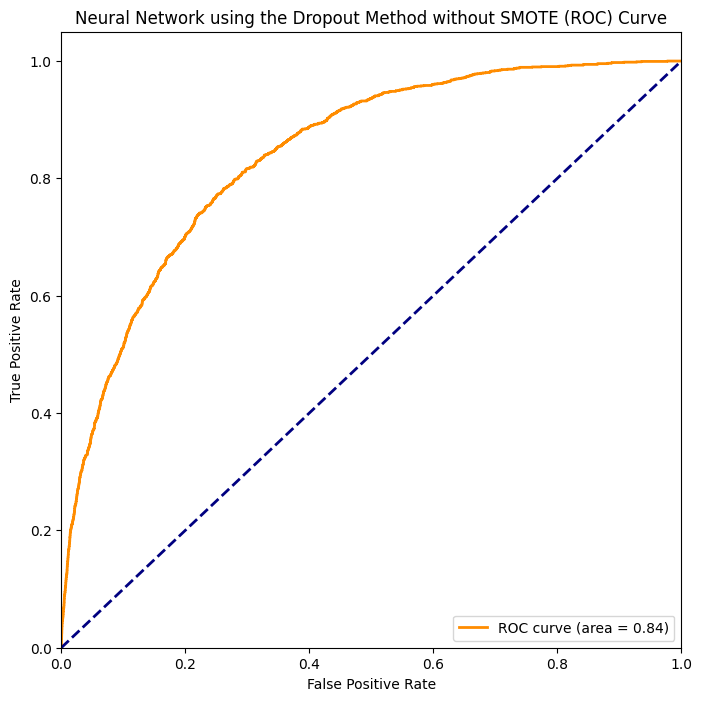

In [62]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network using the Dropout Method without SMOTE (ROC) Curve')
plt.legend(loc='lower right')
plt.show()